# Simulated data from a linear factor model

This notebook shows how to generate data from a linear factor model and use it as input to a synthetic control method for testing or illustration purposes.

In [1]:
from pysyncon import Synth
from pysyncon.generator import LinearFactorModel

In [2]:
seed = 123456

n_units = 20
n_observable = 7
n_unobservable = 17
n_periods_pre = 50
n_periods_post = 10

effect_dist = (20, 30)

We generate data from a Linear Factor Model with 20 units (unit 1 is always the treated unit here, so there are 19 control units and 1 treated unit) with 7 observable covariates and 17 unobservable covariates. We fix 50 time periods prior to the treatment and 10 time periods post-treatment. We choose the treatment effect to be selected over time from the interval $[20, 30]$ (it is sampled from a uniform distribution on the selected interval).

In [3]:
lfm = LinearFactorModel(effect_dist=effect_dist, seed=seed)

X0, X1, Z0, Z1 = lfm.generate(
    n_units=n_units,
    n_observable=n_observable,
    n_unobservable=n_unobservable,
    n_periods_pre=n_periods_pre,
    n_periods_post=n_periods_post,
)

The `generate` method returns the matrices of covariate values for the control units and treated units (`X0` and `X1` respectively) and the outcome variables for the control units and treated units (`Z0` and `Z1` respectively). These can then be used as input to a synthetic control method.

In [4]:
synth = Synth()
synth.fit(X0=X0, X1=X1, Z0=Z0, Z1=Z1)

synth.weights(threshold=0.01)

9     0.181
11    0.382
14    0.178
17    0.259
Name: weights, dtype: float64

The synthetic control obtained from the optimisation is: $$\text{Synthetic Control} = 0.181 \times \text{Unit 9} + 0.382 \times \text{Unit 11} + 0.178 \times \text{Unit 14} + 0.259 \times \text{Unit 17}.$$

We can generate plots of the path of the synthetic control unit versus the treated unit and for the gaps (difference between synthetic control unit and treated) where we have to supply the outcome matrices to the class methods (`Z0` and `Z1`)`.

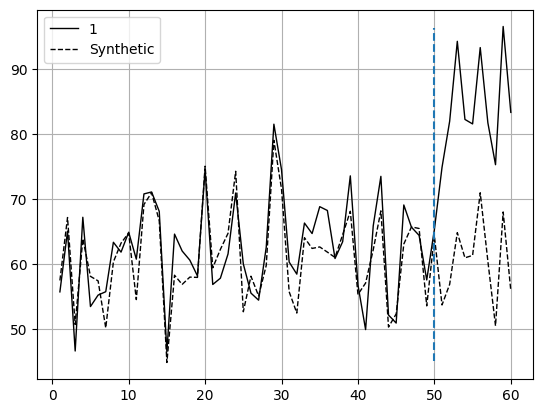

In [5]:
synth.path_plot(treatment_time=n_periods_pre, Z0=Z0, Z1=Z1)

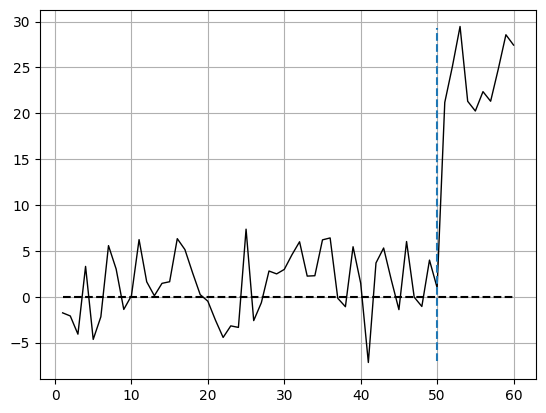

In [6]:
synth.gaps_plot(treatment_time=n_periods_pre, Z0=Z0, Z1=Z1)

We can generate more data comparing the synthetic control unit and the treated unit using the summary function.

In [7]:
synth.summary(X0=X0, X1=X1)

,V,treated,synthetic,sample mean
observable1,0.014,0.954,0.578,0.557
observable2,0.306,0.813,0.801,0.467
observable3,0.000,0.055,0.296,0.480
observable4,0.032,0.952,0.742,0.511
observable5,0.114,0.460,0.512,0.448
observable6,0.298,0.437,0.431,0.417
observable7,0.236,0.405,0.416,0.411


We can calculate some metrics about the goodness of the fit between the synthetic control unit and the treated unit prior to treatement for comparison purposes: mean-square prediction error, mean absolute percentage error and mean absolute error.

In [8]:
print("MSPE:", round(synth.mspe(Z0=Z0, Z1=Z1), 3))
print("MAPE:", round(synth.mape(Z0=Z0, Z1=Z1), 3))
print("MAE:", round(synth.mae(Z0=Z0, Z1=Z1), 3))

MSPE: 110.667
MAPE: 0.111
MAE: 6.595


Get the average treatment effect on the treated unit (ATT) observed over the post-treatment time-periods ($t=51$ to $t=60$).

In [9]:
synth.att(time_period=[51, 52, 53, 54, 55, 56, 57, 58, 59, 60], Z0=Z0, Z1=Z1)

{'att': 24.18373557536277, 'se': 1.0711847190939772}

Calculate 95% confidence intervals for the treatment effect for time periods $t=51, 52, 53$.

In [10]:
_ = synth.confidence_interval(
    alpha=0.05,
    time_periods=[51, 52, 53],
    pre_periods=list(range(1, 51)),
    X0=X0,
    X1=X1,
    Z0=Z0,
    Z1=Z1,
)

(1/3) Calculating confidence interval for time-period t=51...
	95.0% CI: [14.261, 29.062]
(2/3) Calculating confidence interval for time-period t=52...
	95.0% CI: [18.728, 32.022]
(3/3) Calculating confidence interval for time-period t=53...
	95.0% CI: [22.745, 37.229]
